# **Detection**

**Subsections:**

- **Pre-processing:** `absdiff` and removal of the Background off the track
- **Processing:** `HoughCircle`
- **Post-processing**

In [ ]:
# Import libraries
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Loading the video file

- _notebook_dir -> /home/davic/projects/IACV_project/bowling-analysis/notebook/ball_detection_
- _project_root -> /home/davic/projects/IACV_project/bowling-analysis_
- _video_path   -> /home/davic/projects/IACV_project/bowling-analysis/data/recording_2/Recording_2_normal_speed.mp4_

In [217]:
# Define the relative path to the video file (authomatic)
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_2" / "Recording_2_normal_speed.mp4"
video_path = str(video_path)

csv_points_path = project_root / "data" / "auxiliary_data" / "lane_points" / "lane_points_2_frame_100.csv"

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 276.0


## Pre-processing

Auxiliary functions

In [218]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

This is for testing the techniques. I read two consecutive frames

In [219]:
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 130) # frame to test
prev_ret, prev_frame = cap.read() # read frame
ret, frame = cap.read() # read following frame

# Check
if not prev_ret or not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

**Techniques for pre-processing**

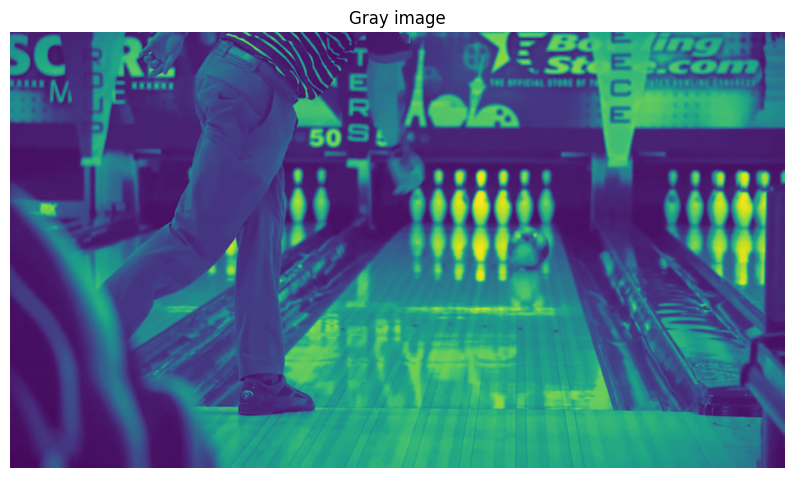

In [220]:
# Convert to grayscale both frames
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Apply a little bit of Blur
gray = cv2.GaussianBlur(gray, (5, 5), 0)
prev_gray = cv2.GaussianBlur(prev_gray, (5, 5), 0)

showImage(gray, "Gray image")

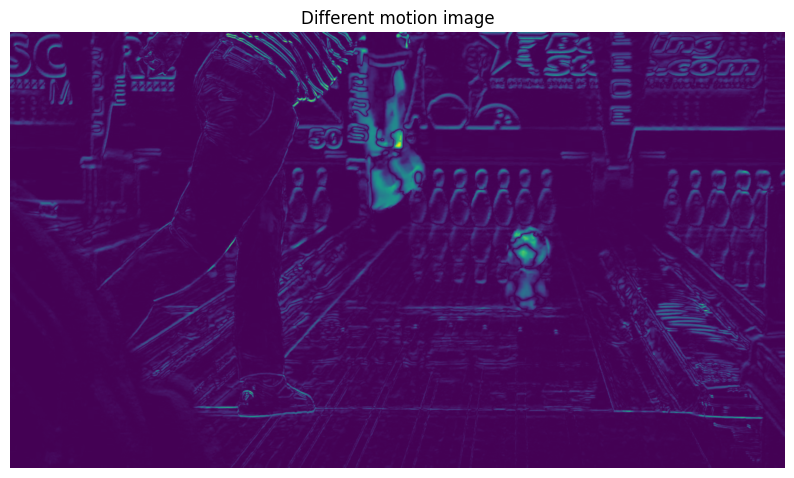

In [221]:
# Compute frame difference with smoothed background
background = prev_gray.copy().astype("float")
bg_diff = cv2.absdiff(gray, cv2.convertScaleAbs(background))

showImage(bg_diff, "Different motion image")

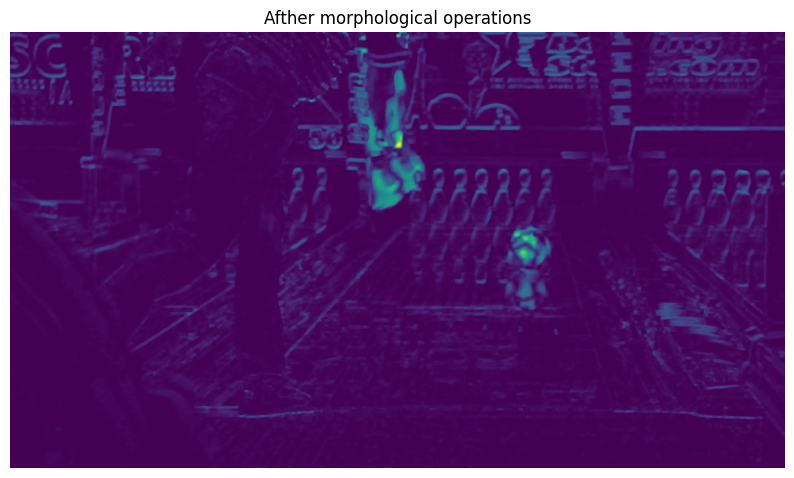

In [222]:
# Morphological operations to reduce noise
kernel = np.ones((5, 5), np.uint8)
thresh = cv2.morphologyEx(bg_diff, cv2.MORPH_OPEN, kernel)  # Remove small noise
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)  # Fill gaps

showImage(thresh, "Afther morphological operations")

## Background removal

In [223]:
def remove_background(filename, image):
    # Read the quadrilateral points from the CSV file
    points = pd.read_csv(filename).values[:, :2].astype(np.int32)  # Extract only x, y columns
    
    # Identify the two points with the lowest Y coordinates
    sorted_indices = np.argsort(points[:, 1])  # Sort by Y values
    points[sorted_indices[:2], 1] -= 100  # Move the two upper points up by 100 pixels

    # Create a mask with the same dimensions as the image, initialized to black (0)
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # Fill the quadrilateral area in the mask with white (255)
    cv2.fillPoly(mask, [points], 255)
    
    # Apply the mask to the image
    result = cv2.bitwise_and(image, image, mask=mask)
    
    return result

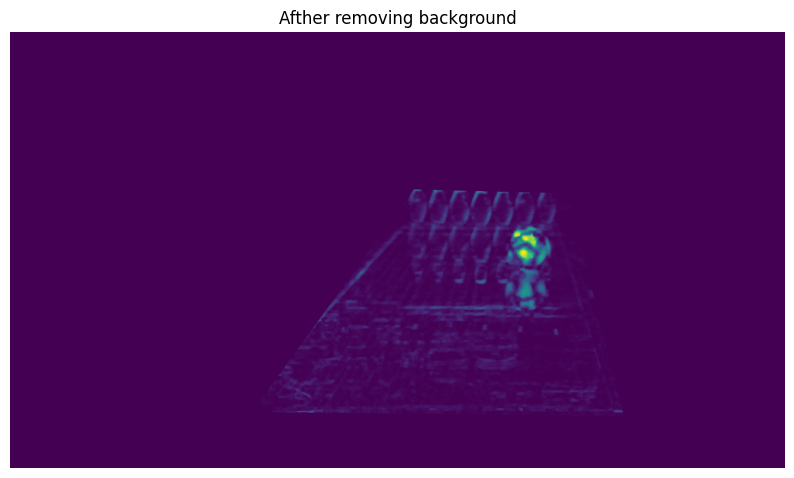

In [224]:
clean_image = remove_background(csv_points_path, thresh)
showImage(clean_image, "Afther removing background")

In [225]:
cap.release()

## Procesing

Use of pure Hough circle detection

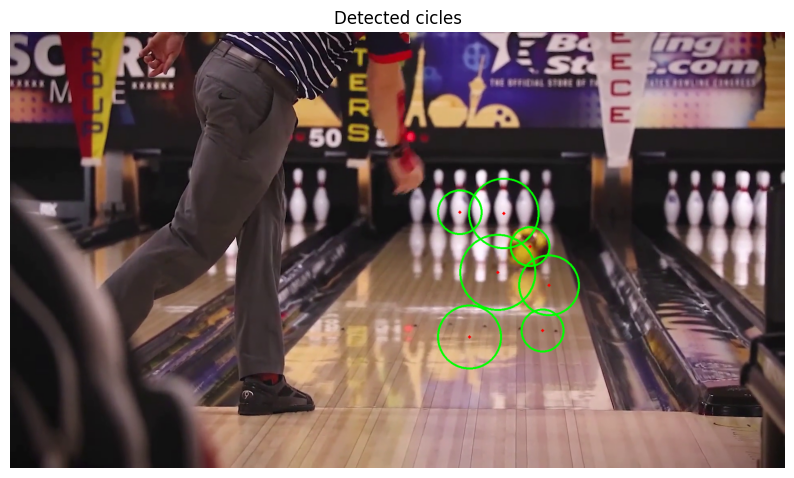

In [226]:
# Hough Circle Detection
circles = cv2.HoughCircles(
    clean_image, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,  # Inverse ratio of resolution
    minDist=100,  # Minimum distance between detected centers
    param1=50,  # Higher threshold for Canny edge detector
    param2=20,  # Accumulator threshold for circle detection
    minRadius=30,  # Minimum radius of detected circles
    maxRadius=100   # Maximum radius of detected circles
)

# Draw circles if detected
if circles is not None:
    circles = np.uint16(np.around(circles))
    output = frame.copy()
    for i in circles[0, :]:
        cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 3)  # Draw circle
        cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)  # Draw center

    output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    showImage(output_rgb, "Detected cicles")
else:
    print("No circles detected")

Improvements:

- change dynamically the parameters `minRadius` and `maxRadius`.
- use dynamically the detection of the track
- calculate dynamically how much to raise the Y points of the track and when raise them.
- add the fact that the coordinates of the center of the ball do not change so much between two consecutive frames.

## Post-procesing

There is no mutch to do here

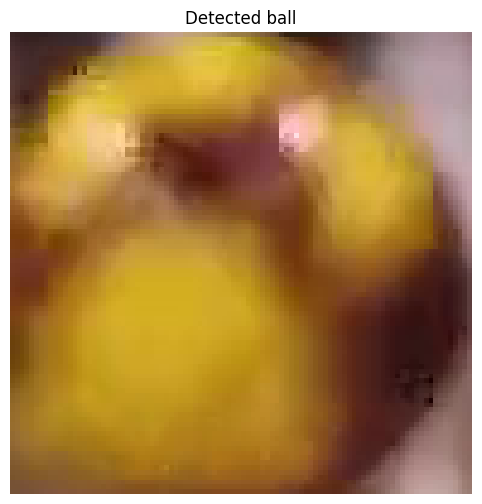

In [227]:
if circles is not None:
    x, y, r = circles[0, 0]  # Get first detected circle
    ball = frame[y-r:y+r, x-r:x+r]  # Crop the ball region
    if ball.size > 0:
        ball_rgb = cv2.cvtColor(ball, cv2.COLOR_BGR2RGB)
        showImage(ball_rgb, "Detected ball")